## This notebook loads the data, preprocesses it, runs linear regression on the full dataset, last week, and last 8 weeks, and visualizes the results.

In [98]:
import os
from utils.preprocessing import load_data, preprocess_data, filter_weeks
from utils.regression_analysis import run_regression
from utils.visualization import plot_coefficients, plot_individual_variable

# Ensure output directory exists
os.makedirs('output', exist_ok=True)

### 1. Load the Data

In [99]:
## Machine learning Superrvised regression example
# Load data
df = load_data()

Data loaded from C:\Users\93810\Downloads\regression test.csv
First 5 rows:
  Dispatch Date      Region District Name              Customer Name  \
0      4-Aug-25        East         Jinja             Gorreti Nagayi   
1      8-Aug-25       North          Gulu                ABER BARBRA   
2      4-Aug-25        East       Buyende                 MAIRI JOHN   
3      4-Aug-25        East        Iganga  NABULUMBA MADINA BALIKOWA   
4      8-Aug-25  North East          Lira                Okello Aron   

  DOCs Ordered DOCs Received  DOC Dead Upon Arrival  DOC Dead 1st Week  \
0          153           117                   33.0               40.0   
1          102           102                    NaN               16.0   
2          408           408                    NaN               45.0   
3          510           510                    NaN               50.0   
4          153           153                    NaN               15.0   

   first_week_mortality hatchery hatcher sette

### 2. Preprocess the Data

In [100]:
# Parse dates, add a week column, drop rows with missing target, and fill missing predictors with 'Unknown'.
# Define dependent and independent variables
y_col = "first_week_mortality"
x_cols = ["hatchery", "hatcher", "setter", "DriverName", 
          "VehicleNumber", "source_of_eggs", "CustomerType"]

df = preprocess_data(df, y_col, x_cols)

print("Independent variables:", x_cols)
print("NaNs in y:", df[y_col].isna().sum())
print("NaNs in X columns:\n", df[x_cols].isna().sum())
print(f"Data shape after dropping NaN y rows: {df.shape}")

Independent variables: ['hatchery', 'hatcher', 'setter', 'DriverName', 'VehicleNumber', 'source_of_eggs', 'CustomerType', 'Week']
NaNs in y: 0
NaNs in X columns:
 hatchery          0
hatcher           0
setter            0
DriverName        0
VehicleNumber     0
source_of_eggs    0
CustomerType      0
Week              0
dtype: int64
Data shape after dropping NaN y rows: (492, 19)


d:\Regression\utils\preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x_cols] = df[x_cols].fillna('Unknown')


### 3. Week-Based Filtering

In [101]:
# Create subsets for the most recent week and the last 8 weeks.
df_last_week, df_last_8_weeks = filter_weeks(df)

### 4. Regression & Coefficient Plots

In [102]:
# Run OLS regression on each subset and save a horizontal bar chart of the top 15 significant coefficients (p < 0.05).


# Full dataset
print("\nRunning regression on full dataset...")
model_full, _, _ = run_regression(df, x_cols, y_col, "Full_Dataset")


# Last week
print("\nRunning regression on last week...")
model_last_week, _, _ = run_regression(df_last_week, x_cols, y_col, "Last_Week")


# Last 8 weeks
print("\nRunning regression on last 8 weeks...")
model_last_8_weeks, _, _ = run_regression(df_last_8_weeks, x_cols, y_col, "Last_8_Weeks")



Running regression on full dataset...

Full_Dataset Regression Summary:
                             OLS Regression Results                             
Dep. Variable:     first_week_mortality   R-squared:                       0.096
Model:                              OLS   Adj. R-squared:                  0.037
Method:                   Least Squares   F-statistic:                     1.628
Date:                  Thu, 02 Oct 2025   Prob (F-statistic):             0.0207
Time:                          17:50:41   Log-Likelihood:                 1171.7
No. Observations:                   492   AIC:                            -2281.
Df Residuals:                       461   BIC:                            -2151.
Df Model:                            30                                         
Covariance Type:              nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------

R-squared: 0.096—Only 9.6% of variation in mortality is explained by the independent variables. 

Adj. R-squared: 0.037—Even lower (3.7%) after penalizing for 30+ variables; indicates the model isn't worth the complexity—many variables add noise.

F-statistic: 1.628, Prob (F-statistic): 0.028—Overall model is significant (p<0.05), so the independent variables collectively matter (not pure chance), but weakly.

In [104]:
def plot_coefficients(model, feature_names, subset_name):
    """
    Plot significant coefficients from the regression model.
    
    Args:
        model: Fitted statsmodels OLS model
        feature_names: List of feature names from preprocessor (optional)
        subset_name (str): Name of the dataset subset (for title)
    """
    if model is None:
        print(f"No model available for {subset_name}, skipping visualization")
        return
    
    # Extract coefficients and p-values
    coefs = model.params[1:]  # Skip const
    pvals = model.pvalues[1:]
    
    # Filter significant (p<0.05) and sort by abs(coef)
    sig_mask = pvals < 0.05
    sig_coefs = coefs[sig_mask]
    sig_names = model.params.index[1:][sig_mask]  # Feature names
    sig_abs = np.array(np.abs(sig_coefs))  # Convert to numpy array
    sorted_idx = np.argsort(sig_abs)[::-1][:15]  # Top 15
    
    top_names = sig_names[sorted_idx]
    top_abs = sig_abs[sorted_idx]
    top_coefs = np.array(sig_coefs)[sorted_idx]  # Convert to numpy array
    
    if len(top_names) == 0:
        print(f"No significant coefficients (p<0.05) found for {subset_name}")
        return
    
    # Plot horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['red' if c > 0 else 'blue' for c in top_coefs]
    bars = ax.barh(top_names, top_abs, color=colors, alpha=0.7)
    ax.set_xlabel('Absolute Impact on First-Week Mortality (|Coefficient|)')
    ax.set_title(f'Top Drivers of First-Week Mortality ({subset_name})')
    ax.invert_yaxis()  # Largest on top
    
    # Add value labels
    for i, bar in enumerate(bars):
        ax.text(bar.get_width() + 0.0001, bar.get_y() + bar.get_height()/2, f'{top_abs[i]:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()

def plot_individual_variable(df_last_week, df_last_8_weeks, variable, y_col):
    """
    Plot box plots of y_col by variable categories for last week and last 8 weeks.
    
    Args:
        df_last_week (pd.DataFrame): Data for last week
        df_last_8_weeks (pd.DataFrame): Data for last 8 weeks
        variable (str): Independent variable to plot
        y_col (str): Target column name
    """
    if variable not in df_last_week.columns or variable not in df_last_8_weeks.columns:
        print(f"Variable {variable} not found in the dataset")
        return
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Last week box plot
    if not df_last_week.empty:
        data_last_week = [df_last_week[df_last_week[variable] == cat][y_col].values 
                          for cat in df_last_week[variable].unique()]
        labels_last_week = df_last_week[variable].unique()
        ax1.boxplot(data_last_week, labels=labels_last_week, vert=False)
        ax1.set_title('Last Week')
        ax1.set_xlabel('First-Week Mortality')
        ax1.set_ylabel(variable)
    else:
        ax1.text(0.5, 0.5, 'No data for Last Week', ha='center', va='center')
        ax1.set_title('Last Week')
        ax1.set_xlabel('First-Week Mortality')
        ax1.set_ylabel(variable)
    
    # Last 8 weeks box plot
    if not df_last_8_weeks.empty:
        data_last_8_weeks = [df_last_8_weeks[df_last_8_weeks[variable] == cat][y_col].values 
                             for cat in df_last_8_weeks[variable].unique()]
        labels_last_8_weeks = df_last_8_weeks[variable].unique()
        ax2.boxplot(data_last_8_weeks, labels=labels_last_8_weeks, vert=False)
        ax2.set_title('Last 8 Weeks')
        ax2.set_xlabel('First-Week Mortality')
    else:
        ax2.text(0.5, 0.5, 'No data for Last 8 Weeks', ha='center', va='center')
        ax2.set_title('Last 8 Weeks')
        ax2.set_xlabel('First-Week Mortality')
    
    plt.suptitle(f'Distribution of First-Week Mortality by {variable}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

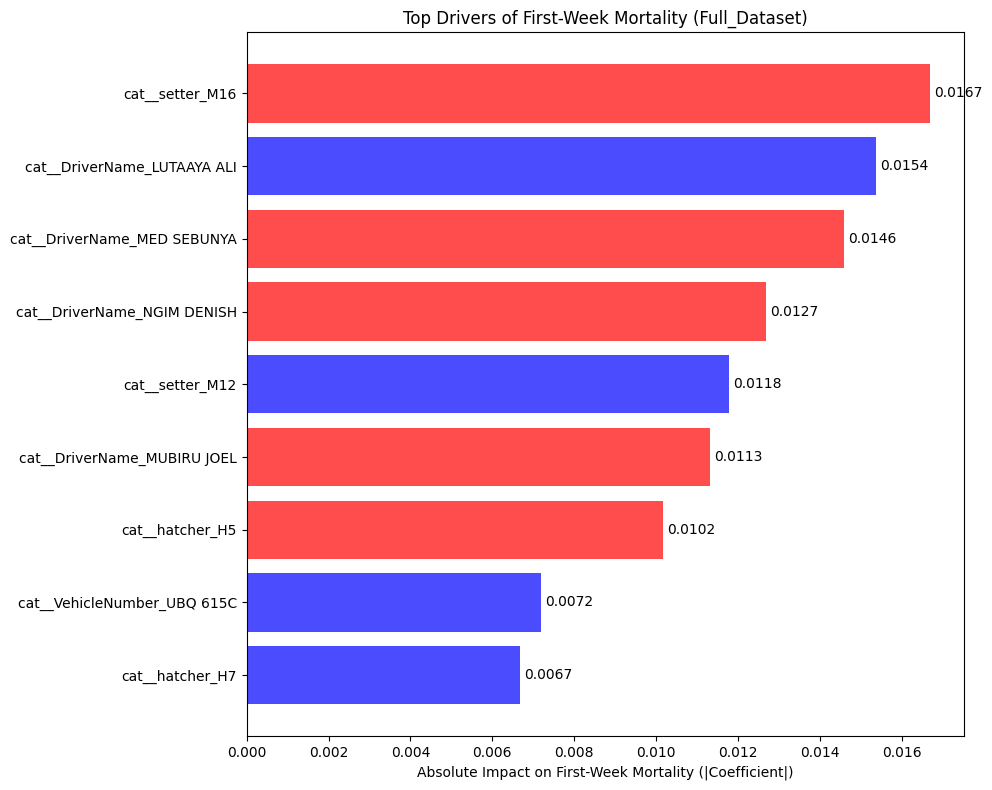

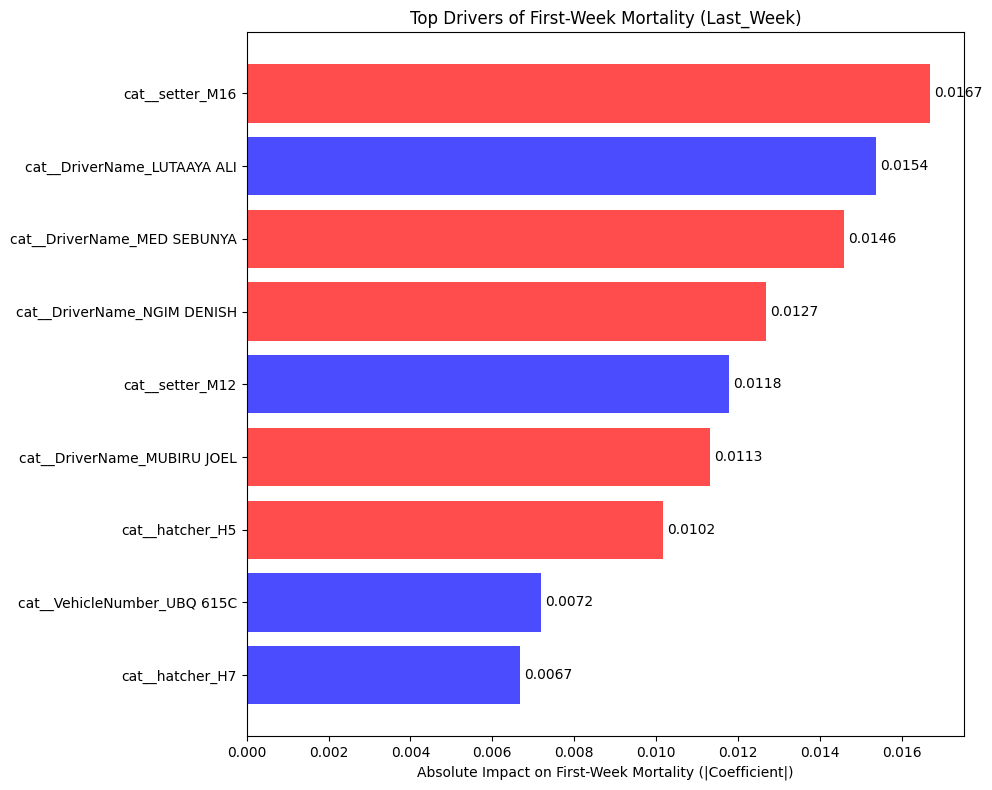

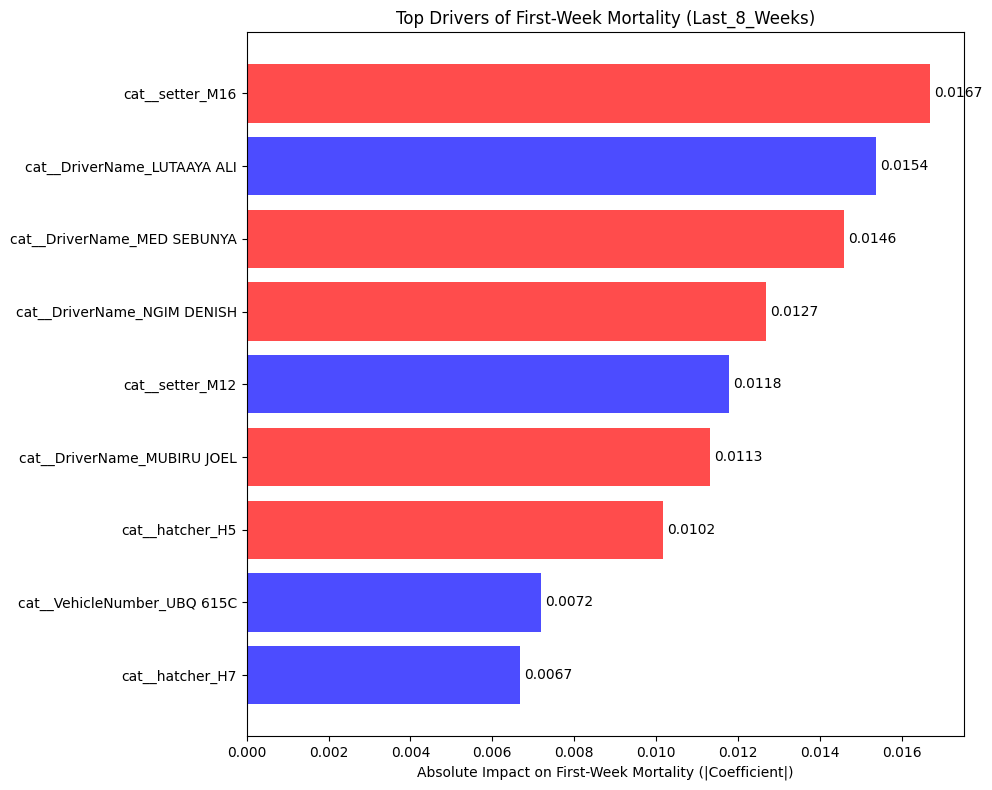

In [105]:
plot_coefficients(model_full, None, "Full_Dataset")  # Feature names not needed for plot
plot_coefficients(model_last_week, None, "Last_Week")
plot_coefficients(model_last_8_weeks, None, "Last_8_Weeks")

### 5. Individual Variable Visualization


Plotting hatchery distribution...


C:\Users\93810\AppData\Local\Temp\ipykernel_74492\1971752581.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(data_last_week, labels=labels_last_week, vert=False)
C:\Users\93810\AppData\Local\Temp\ipykernel_74492\1971752581.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data_last_8_weeks, labels=labels_last_8_weeks, vert=False)


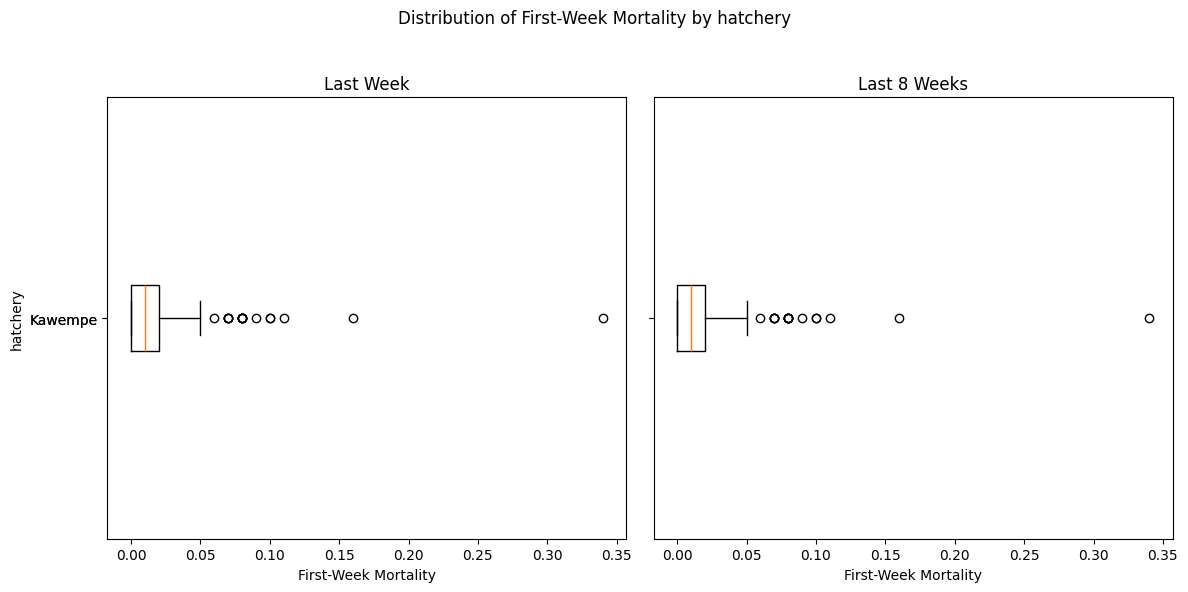

In [106]:
print("\nPlotting hatchery distribution...")
plot_individual_variable(df_last_week, df_last_8_weeks, 'hatchery', y_col)